In [76]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from scipy.integrate import simps
from cdetools.cdf_coverage import cdf_coverage
from sklearn.neural_network import MLPClassifier
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import ipdb

# generate data

## 4 types of GalSim images

In [16]:
#### 1000 training images

with open("data/galsim_simulated_2500gals_lambda0.4_theta3.14159_2021-05-20-17-01.pkl", 'rb') as handle:
    group1 = pickle.load(handle)
with open("data/galsim_simulated_2500gals_lambda0.4_theta2.3562_2021-05-20-17-42.pkl", 'rb') as handle:
    group2 = pickle.load(handle)
with open("data/galsim_simulated_2500gals_lambda0.4_theta1.5708_2021-05-20-17-08.pkl", 'rb') as handle:
    group3 = pickle.load(handle)
with open("data/galsim_simulated_2500gals_lambda0.4_theta0.7854_2021-05-20-17-44.pkl", 'rb') as handle:
    group4 = pickle.load(handle)

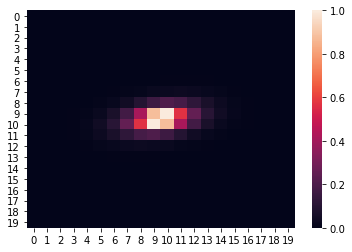

In [17]:
sns.heatmap(group1['galaxies_generated'][0])
plt.show()

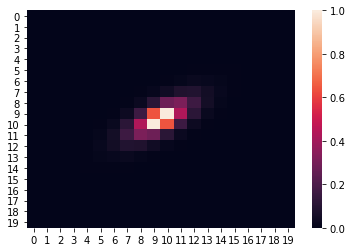

In [18]:
sns.heatmap(group2['galaxies_generated'][0])
plt.show()

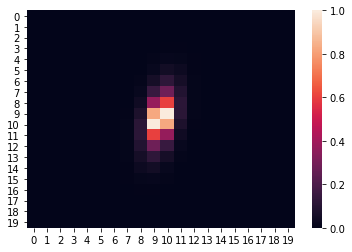

In [19]:
sns.heatmap(group3['galaxies_generated'][0])
plt.show()

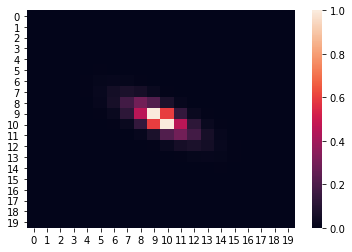

In [20]:
sns.heatmap(group4['galaxies_generated'][0])
plt.show()

In [47]:
#### 1000 test images

with open("data/galsim_simulated_250gals_lambda0.4_theta3.14159_2021-05-20-18-14.pkl", 'rb') as handle:#
    test1 = pickle.load(handle)
with open("data/galsim_simulated_250gals_lambda0.4_theta2.3562_2021-05-20-18-14.pkl", 'rb') as handle:
    test2 = pickle.load(handle)
with open("data/galsim_simulated_250gals_lambda0.4_theta1.5708_2021-05-20-18-14.pkl", 'rb') as handle:
    test3 = pickle.load(handle)
with open("data/galsim_simulated_250gals_lambda0.4_theta0.7854_2021-05-20-18-14.pkl", 'rb') as handle:
    test4 = pickle.load(handle)

In [48]:
gal_img1 = group1['galaxies_generated']
gal_img2 = group2['galaxies_generated']
gal_img3 = group3['galaxies_generated']
gal_img4 = group4['galaxies_generated']
all_gal_imgs = np.vstack([gal_img1, gal_img2, gal_img3, gal_img4])
all_gal_imgs.shape

(10000, 20, 20)

In [49]:
test_img1 = test1['galaxies_generated']
test_img2 = test2['galaxies_generated']
test_img3 = test3['galaxies_generated']
test_img4 = test4['galaxies_generated']
all_test_imgs = np.vstack([test_img1, test_img2, test_img3, test_img4])
all_test_imgs.shape

(1000, 20, 20)

In [50]:
all_train_test_imgs = np.vstack([all_gal_imgs, all_test_imgs])
all_train_test_imgs.shape

(11000, 20, 20)

In [51]:
#with open('galsim_conformal_imgs_20210520.pkl', 'wb') as handle:
#    pickle.dump(all_train_test_imgs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [96]:
test_gal1 = test1['galaxies_generated'].reshape(250,400)
test_gal2 = test2['galaxies_generated'].reshape(250,400)
test_gal3 = test3['galaxies_generated'].reshape(250,400)
test_gal4 = test4['galaxies_generated'].reshape(250,400)
all_test_gals = np.vstack([test_gal1, test_gal2, test_gal3, test_gal4])

In [97]:
#with open('galsim_conformal_test_imgs_20210521.pkl', 'wb') as handle:
#    pickle.dump(all_test_gals, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 4 distributions with same mean and variance (gaussian, uniform, exponential, bimodal)

## do this x10 for different SD groups
## do a mixture of Gaussians instead

In [26]:
# N(1,1)
z1 = np.random.normal(1, 1, size=2500)

In [25]:
# Unif(1-sqrt(3),1+sqrt(3))
z2 = np.random.uniform(1-np.sqrt(3), 1+np.sqrt(3), size=2500)

In [24]:
# Expo(1)
z3 = np.random.exponential(1, size=2500)

In [37]:
# 0.5N(0.25,0.4375) + 0.5N(1.75,0.4375)
z4_ind = np.random.binomial(n=1, p=0.5, size=2500)
z4 = z4_ind*np.random.normal(0.25, 0.4375, size=2500) + (1-z4_ind)*np.random.normal(1.75, 0.4375, size=2500)

C:\Users\dzhao\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\dzhao\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\dzhao\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

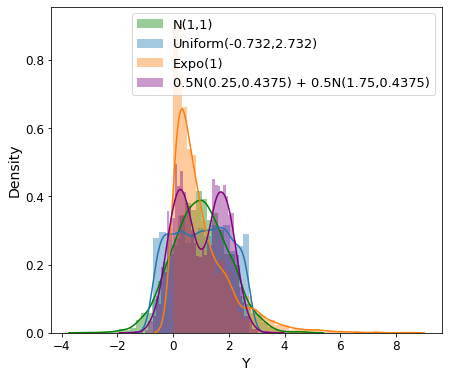

In [40]:
fig, ax = plt.subplots(figsize=(7,6))
sns.distplot(z1, color='green', label='N(1,1)', ax=ax)
sns.distplot(z2, label='Uniform(-0.732,2.732)', ax=ax)
sns.distplot(z3, label='Expo(1)', ax=ax)
sns.distplot(z4, color='purple', label='0.5N(0.25,0.4375) + 0.5N(1.75,0.4375)', bins=50, ax=ax)

plt.legend(fontsize=13)
plt.xlabel('Y', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('z_dists_v1.pdf')

In [41]:
all_zs = np.hstack([z1, z2, z3, z4])

In [42]:
test_z1 = np.random.normal(1, 1, size=250)
test_z2 = np.random.uniform(1-np.sqrt(3), 1+np.sqrt(3), size=250)
test_z3 = np.random.exponential(1, size=250)
test_z4_ind = np.random.binomial(n=1, p=0.5, size=250)
test_z4 = test_z4_ind*np.random.normal(0.25, 0.4375, size=250) + (1-test_z4_ind)*np.random.normal(1.75, 0.4375, size=250)

In [43]:
all_test_zs = np.hstack([test_z1, test_z2, test_z3, test_z4])

In [44]:
all_train_test_zs = np.hstack([all_zs, all_test_zs])

In [52]:
#with open('z_conformal_20210520.pkl', 'wb') as handle:
#    pickle.dump(all_train_test_zs, handle, protocol=pickle.HIGHEST_PROTOCOL)

# fit neural density model

In [53]:
with open('CMDN_test_k=1_2021-05-20-19-22.pkl', 'rb') as handle:
    test_pis, test_mus, test_sigmas = pickle.load(handle)

In [54]:
test_pis = test_pis.detach().numpy()
test_mus = test_mus.detach().numpy()
test_sigmas = test_sigmas.detach().numpy()

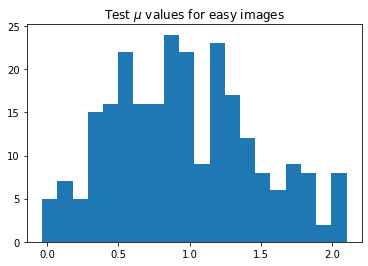

In [105]:
plt.hist(test_mus[:,0][750:1000], bins=20)
plt.title("Test $\mu$ values for easy images")
#plt.savefig("easy_biased_mus.png")
plt.show()

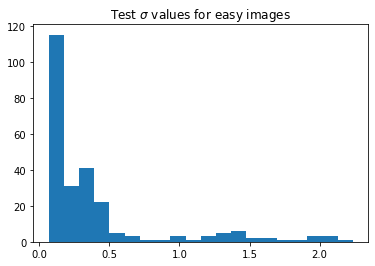

In [109]:
plt.hist(test_sigmas[:,0][750:1000], bins=20)
plt.title("Test $\sigma$ values for easy images")
#plt.savefig("easy_biased_mus.png")
plt.show()

In [72]:
def compute_mixture_pdf(alpha, pis, sigmas, mus):
    assert(pis.shape[0] == sigmas.shape[0] == mus.shape[0])
    density = 0
    for j in range(pis.shape[0]):
        density += pis[j] * norm.pdf(x=alpha, loc=mus[j], scale=sigmas[j])
    return density

In [82]:
# for each observed (test) data point, calc pdf value (based on out pi, mu, sigma) of theta across a theta grid
alpha_grid = np.linspace(-2, 4, 1501)
# nested list comprehension ftw
all_pdf_values_test = np.array([[compute_mixture_pdf(alpha_grid[t],
                                 test_pis[i], test_sigmas[i], test_mus[i])
                                 for t in range(len(alpha_grid))] for i in range(1000)])

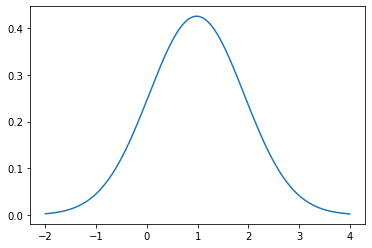

In [83]:
plt.plot(alpha_grid, all_pdf_values_test[0])

In [84]:
den_integral = simps(all_pdf_values_test[0, :], x=alpha_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

Integral of the first density integrates to: 1.00


In [85]:
# obs samples (theta,x) from joint distribution --> theta as obs posterior sample given x
pit_values = cdf_coverage(all_pdf_values_test, alpha_grid, all_test_zs)

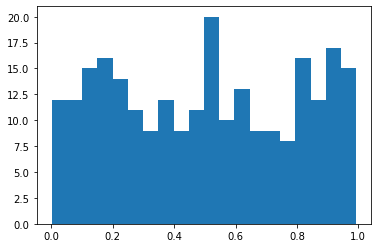

In [113]:
plt.hist(pit_values[:250], bins=20)
plt.show()

In [94]:
#with open('conformal_pit_values_20210521.pkl', 'wb') as handle:
#    pickle.dump(pit_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

# run CDE diagnostics

In [99]:
with open("GalSim_all_rhat_alphas_2021-05-21-15-14.pkl", 'rb') as handle:
    rhat_alphas = pickle.load(handle)

In [114]:
rhat_alphas

,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.99
0,0.002193,0.144401,0.283298,0.368418,0.476768,0.555175,0.630210,0.711961,0.784176,0.886954,0.985612
1,0.003895,0.086520,0.223107,0.320008,0.370108,0.445076,0.566279,0.663114,0.745473,0.854277,0.999127
2,0.003721,0.089756,0.220261,0.314752,0.373377,0.449524,0.573922,0.669959,0.753332,0.863455,0.998959
3,0.002318,0.157719,0.297421,0.381182,0.482294,0.560127,0.630029,0.707406,0.777508,0.878689,0.982002
4,0.003947,0.093145,0.212522,0.294213,0.378176,0.448995,0.603597,0.690275,0.771163,0.874825,0.998476
...,...,...,...,...,...,...,...,...,...,...,...
995,0.005917,0.200484,0.259464,0.271873,0.380837,0.415264,0.485820,0.563847,0.643996,0.660914,0.771175
996,0.009293,0.348332,0.383038,0.401027,0.465480,0.488423,0.540129,0.566869,0.604623,0.551435,0.641867
997,0.006165,0.257565,0.307253,0.323955,0.417109,0.449688,0.513733,0.570533,0.631241,0.622567,0.727035
998,0.008460,0.214778,0.272886,0.278619,0.386628,0.412356,0.480312,0.551356,0.625634,0.613554,0.709974


In [117]:
def draw_PP_plot(index=0, caption="group1"):
    
    use_series = pd.DataFrame(rhat_alphas).T[index]

    plt.style.use("default")
    use_series.plot(style='.', figsize=(5,4), markersize=7)

    lims = [
        np.min([0,0]),  # min of both axes
        np.max([1,1]),  # max of both axes
    ]
    plt.plot(lims, lims, 'r--', alpha=1, zorder=0)
    
    plt.title(caption, fontsize=20)
    plt.xlabel(r'$\alpha$', fontsize=20)
    plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    return

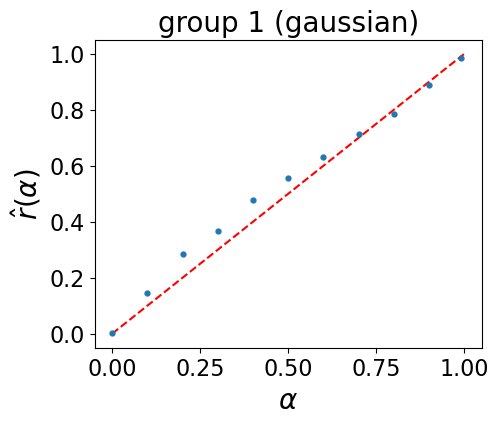

In [120]:
idx = 0
draw_PP_plot(index=idx, caption="group 1 (gaussian)")
#plt.savefig('group1_ex1.png')

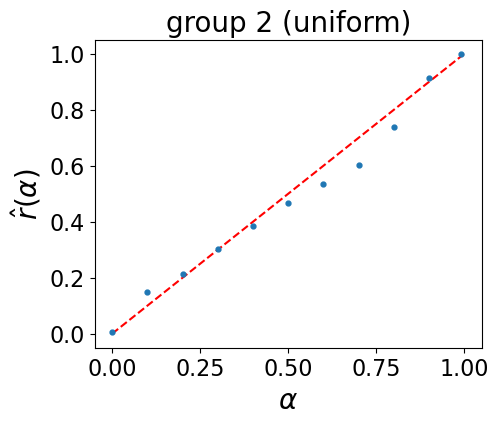

In [123]:
idx = 300
draw_PP_plot(index=idx, caption="group 2 (uniform)")
#plt.savefig('group1_ex1.png')

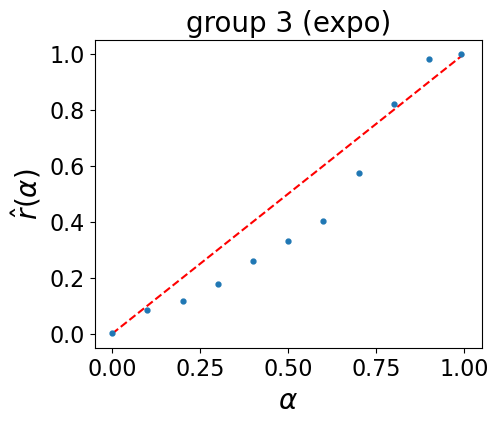

In [124]:
idx = 600
draw_PP_plot(index=idx, caption="group 3 (expo)")
#plt.savefig('group1_ex1.png')

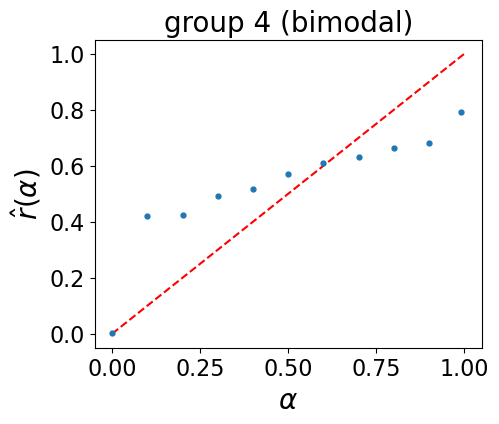

In [125]:
idx = 900
draw_PP_plot(index=idx, caption="group 4 (bimodal)")
#plt.savefig('group1_ex1.png')

# local conformal approach

1) IZBICKI: find localized regions within which to do conformal: valid marginal coverage within each region

- more efficient than Jing and Larry's gridding (get local marginal coverage within each region)

- asymptotically, he needs fit to be perfect, or else won't get CONDITIONAL COVERAGE (at each point x)

- our example wants to show how bad Izbicki's can be if fit isn't perfect (how far from CONDITIONAL COVERAGE we deviate, even in the limit)


1.1) How does Izbicki get local groupings from a fitted CDE model f(y|x)? (Ben has function to do profile distance grouping)

- CD-dist+ groups using profile distance: equally spaced from t=0 to t_max (cutoffs of CDE) --> L2 norm of difference between P1(t) = P_f( {y:f(y|x1) > t} | x1 ) and P2(t) = P_f( {y:f(y|x2) > t} | x2 )

- note: P1(t) is expected mass of y whose CDE values are above t, given x1

- each point x1 has coordinates P1(t) where t varies from 0 to t_max; can do k-means on this to get groupings, chooses k = floor(n/100)

- Euclidean distance between any two points x1, x2: d(x1,x2) = int_{t=0}^{t_max} (P1(t) - P2(t))^2 dt

- he says this helps capture scale (can change example to have 4 with SD 1, 4 with SD 100; **** his will make 2 clear groups based on SD --> we will create 4 groups based on actually differing models **** )


(- Izbicki also has a global conformal approach that uses HPD value as conformal score, instead of CDE value)


1.2) How to do split-conformal on a group?

- held out calibration data set: calculate conformal scores for each observation (CDE PDF value, because low estimated density = "extreme" conformal score; note could also use HPD values)

- now given a test point in that group, build a conformal prediction region (all the potential points with conformal scores less extreme than alpha-quantile of calibrated conformal scores)


2) OURS:

- his grouping can accidentally put together things with different error structure (asymptotic claims very strong), which would fail to get CONDITIONAL COVERAGE


2.1) How to get local groupings using our approach? (we use intuitively an HPD "error distance")

- grid of alphas from 0 to 1

- d(x1,x2) = int_{\alpha=0}^1 (P1(\alpha) - P2(\alpha))^2 d\alpha

- P(\alpha) is estimation of how much mass is truly contained in estimated level set with nominal \alpha coverage

- interestingly will also create a different Euclidean representation --> run k-means

2.2) same as 1.2; emphasize that we should use HPD instead of CDE values --> scaling potentially an issue if using CDE values, because could have different fitted CDEs in the same group



SNEAK ATTACK!!!! How to show ours does better than Izbicki even as n increases? Try many different (e.g. 10?) SD groups of 4 dists. Ours should continue to identify 4 HPD groups (perfect --> conditional coverage for everybody), while his will focus on SD and put similar SDs together ignoring the true qualtiy of fit

n = 100

n = 500

n = 1000

ours gets better as n goes up

his sucks because it's not yet 10 * 4 * 100 = 4000